# **Imbalanced Dataset**

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.preprocessing import image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import zipfile
import os
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
zip_path = '/content/drive/MyDrive/public.zip'
extract_path = '/content/dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [4]:
train_data = '/content/dataset/train/'
val_data = '/content/dataset/validation/'

# **Classes Distribution**

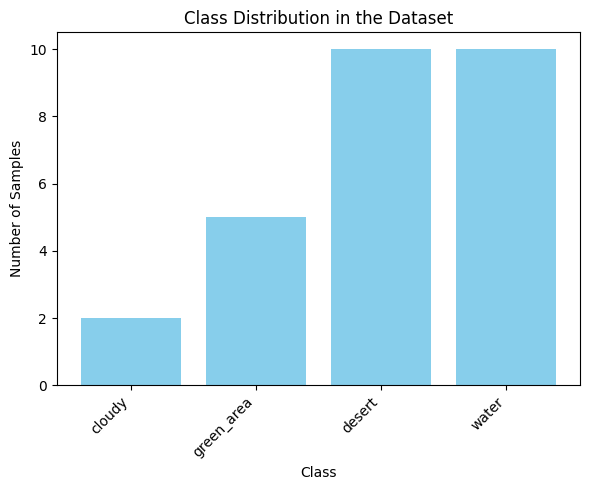

In [6]:
class_folders = os.listdir(val_data)
class_distribution = {}

for class_folder in class_folders:
    class_path = os.path.join(val_data, class_folder)
    num_samples = len(os.listdir(class_path))
    class_distribution[class_folder] = num_samples

class_names = list(class_distribution.keys())
class_counts = list(class_distribution.values())

plt.figure(figsize=(6, 5))
plt.bar(class_names, class_counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in the Dataset')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# **Preprocessing Data**

In [7]:
train_datagen = ImageDataGenerator(
    samplewise_center=True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
validation_datagen = ImageDataGenerator(samplewise_center=True)

In [8]:
num_classes = 4
img_width, img_height = 224, 224
batch_size = 8
epochs = 20

In [9]:
train_generator = train_datagen.flow_from_directory(
    train_data,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True
)

Found 216 images belonging to 4 classes.


In [10]:
validation_generator = validation_datagen.flow_from_directory(
    val_data,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)

Found 27 images belonging to 4 classes.


# **Transfer Learning**

In [11]:
base_model = keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_width, img_height, 3),
    include_top=False)

58889256/58889256 [==============================] - 4s 0us/step


In [12]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
base_model.trainable = False

In [14]:
inputs = keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 4)                 2052      
                                                                 
Total params: 14716740 (56.14 MB)
Trainable params: 2052 (8.02 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [16]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [17]:
train_before = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/20
27/27 [==============================] - 14s 199ms/step - loss: 1.2060 - accuracy: 0.5972 - val_loss: 0.8544 - val_accuracy: 0.6296
Epoch 2/20
27/27 [==============================] - 4s 155ms/step - loss: 0.5709 - accuracy: 0.8472 - val_loss: 0.5611 - val_accuracy: 0.8148
Epoch 3/20
27/27 [==============================] - 5s 185ms/step - loss: 0.4189 - accuracy: 0.9028 - val_loss: 0.4412 - val_accuracy: 0.8889
Epoch 4/20
27/27 [==============================] - 3s 113ms/step - loss: 0.3356 - accuracy: 0.9259 - val_loss: 0.3389 - val_accuracy: 1.0000
Epoch 5/20
27/27 [==============================] - 4s 154ms/step - loss: 0.2769 - accuracy: 0.9306 - val_loss: 0.2913 - val_accuracy: 1.0000
Epoch 6/20
27/27 [==============================] - 5s 184ms/step - loss: 0.2414 - accuracy: 0.9306 - val_loss: 0.2531 - val_accuracy: 1.0000
Epoch 7/20
27/27 [==============================] - 4s 147ms/step - loss: 0.2060 - accuracy: 0.9676 - val_loss: 0.2139 - val_accuracy: 1.0000
Epoch

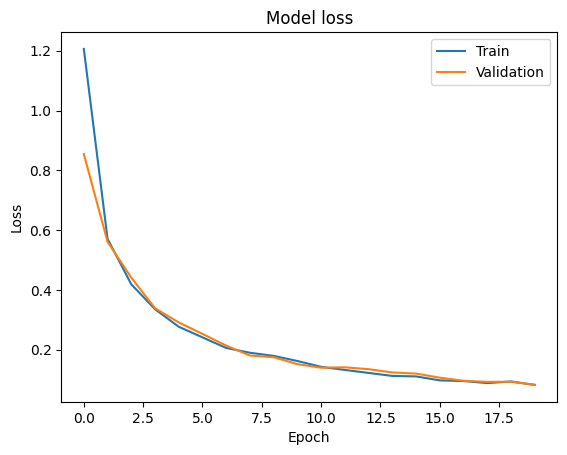

In [18]:
plt.plot(train_before.history['loss'])
plt.plot(train_before.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

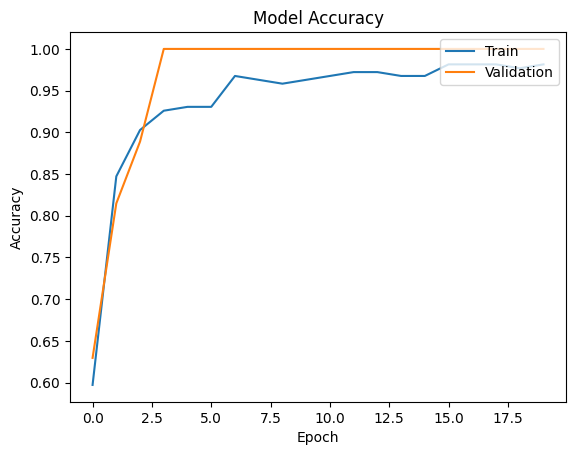

In [19]:
plt.plot(train_before.history['accuracy'])
plt.plot(train_before.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# **Fine Tunning**

In [20]:
base_model.trainable = True
optimizer = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

In [21]:
train_after = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/20
27/27 [==============================] - 13s 160ms/step - loss: 0.1014 - accuracy: 0.9583 - val_loss: 0.1000 - val_accuracy: 0.9630
Epoch 2/20
27/27 [==============================] - 4s 150ms/step - loss: 0.0366 - accuracy: 0.9907 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 3/20
27/27 [==============================] - 6s 205ms/step - loss: 0.0752 - accuracy: 0.9722 - val_loss: 7.9921e-04 - val_accuracy: 1.0000
Epoch 4/20
27/27 [==============================] - 4s 156ms/step - loss: 0.0374 - accuracy: 0.9907 - val_loss: 0.0280 - val_accuracy: 1.0000
Epoch 5/20
27/27 [==============================] - 5s 174ms/step - loss: 0.0121 - accuracy: 1.0000 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 6/20
27/27 [==============================] - 6s 206ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 7/20
27/27 [==============================] - 4s 153ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0065 - val_accuracy: 1.0000
E

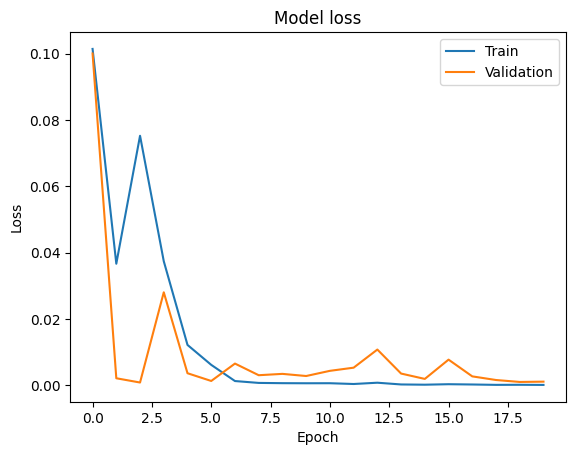

In [22]:
plt.plot(train_after.history['loss'])
plt.plot(train_after.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

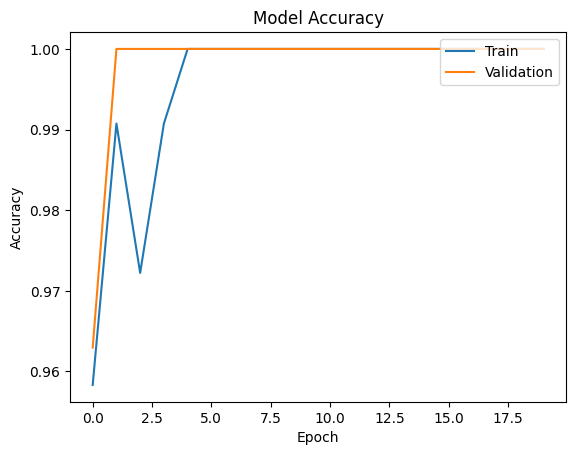

In [23]:
plt.plot(train_after.history['accuracy'])
plt.plot(train_after.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# **Predict New Image**

In [24]:
def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

def classify_new_image(image_path, class_labels):
    show_image(image_path)
    img = image.load_img(image_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    # Make predictions
    predictions = model.predict(img)

    # Interpret predictions
    class_indices = np.argmax(predictions, axis=1)
    predicted_class = class_labels[class_indices[0]]

    return predicted_class

In [25]:
class_labels = ["Cloud", "Desert", "Green area", "Water"]

Desert - https://live.staticflickr.com/7555/15660380862_1da9227364_b.jpg

1/1 [==============================] - 1s 673ms/step
The predicted class is: Desert


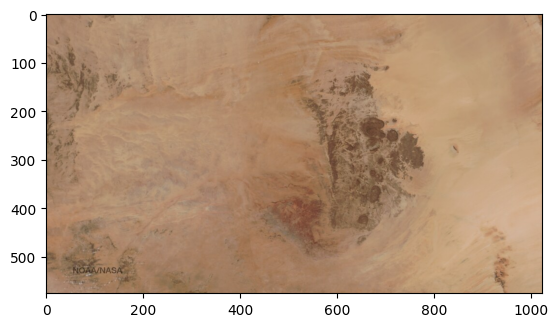

In [26]:
image_path = '/content/desert.jpg'

predicted_class = classify_new_image(image_path, class_labels)

print(f'The predicted class is: {predicted_class}')

Clouds - https://images.fineartamerica.com/images-medium-large-5/satellite-view-of-cloud-spiral-panoramic-images.jpg

1/1 [==============================] - 0s 18ms/step
The predicted class is: Cloud


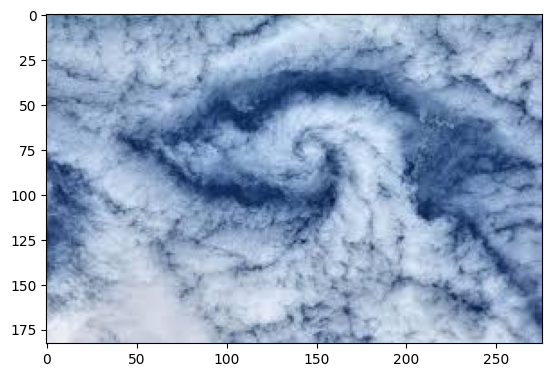

In [27]:
image_path = '/content/clouds.jpeg'

predicted_class = classify_new_image(image_path, class_labels)

print(f'The predicted class is: {predicted_class}')

Forest - https://maps.latitude.to/satellite/8/70/90.jpg

1/1 [==============================] - 0s 29ms/step
The predicted class is: Desert


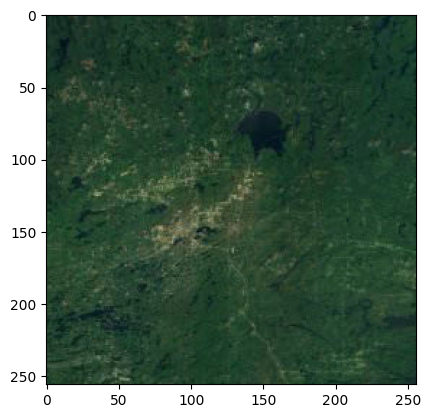

In [28]:
image_path = '/content/forest.jpg'

predicted_class = classify_new_image(image_path, class_labels)

print(f'The predicted class is: {predicted_class}')

SeaLake - https://scitechdaily.com/images/Surface-lake-on-Greenland-Ice-Sheet-scaled.jpg

1/1 [==============================] - 0s 31ms/step
The predicted class is: Water


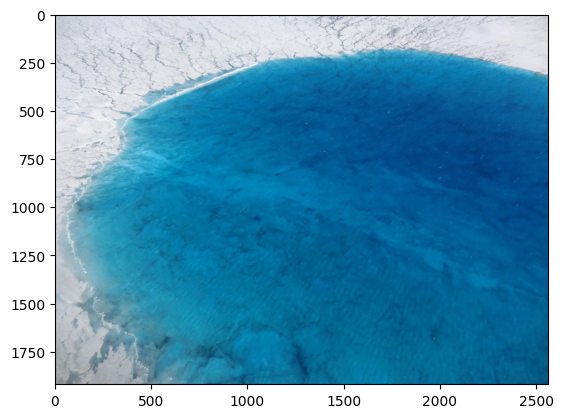

In [29]:
image_path = '/content/lake.webp'

predicted_class = classify_new_image(image_path, class_labels)

print(f'The predicted class is: {predicted_class}')